<center>
<img src="https://i.ibb.co/ZVRt2f7/logo.png" alt="logo" border="0" width=800>

---

Eduard Larrañaga (ealarranaga@unal.edu.co)

---


---
# Neural Network modelling a Time Series.


The file 'ManchasSolares.txt' contains a dataset with the information of the monthly mean number of sunspots begining on january of 1749. We wan to train a neural network that predicts the mean number of sunspots using this information.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


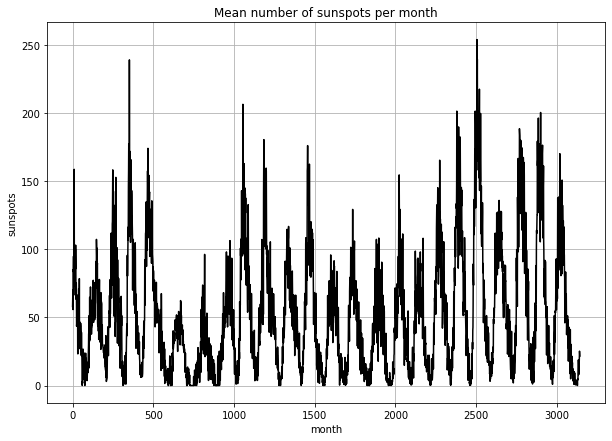

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Reading the data
time, series = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Neural Networks/04. Time Series NN/ManchasSolares.txt', unpack=True)
#time_step


plt.figure(figsize=(10,7))
plt.plot(time,series, color='black')
plt.title('Mean number of sunspots per month')
plt.xlabel(r'month')
plt.ylabel(r'sunspots')
plt.grid()
plt.show()

---
## Preprocessing the data

In order to train the neural network, we will split the data set into training and test subsets. This time we will not split the set by taking randomly chosen data points. Instead, we will take the first 80% of the data to train the neural network and it will be used to predict the (future) behavior in the remaining 20% of the dataset. 

In [ ]:
# split data into validation and training datasets
split_time = int(len(time)*0.8)
time_train = time[:split_time]
x_train = series[:split_time]

time_test = time[split_time:]
x_test = series[split_time:]

The idea is that the feature is a certain number of values in the series, while the label (or target) will be the next value. The number of values that we will treat as the feature will be called the **window size**. Hence, we said that we're taking a window of the data and training an ML model to predict the next value. 
For example, if we take our time series data 60 days at a time, we will use these 60 values as the feature and the next value is the label.

We will use the function [tensorflow.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create a `dataset`from the series. 

Then, the method [dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) creates the windows (subsets of elements of the input dataset). The first argument in the method determines the size of each window. The `shift` argument determines the number of inputs elements to shift between the start of each window`
Finally, the `drop_remainder` argument is set to `True`, so that the last windows should be dropped if their size is smaller than the chosen `size`.

The [dataset.flat_map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method is used to flatten the dataset of windows into a single dataset. The argument in this function is a function that takes the element from the dataset and returns a dataset. Then, the method chains together all the resulting datasets sequntially. Note that we use the [window.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method in the function. This method combines consecutive elements of the dataset into batches with a size given by its argument.

The method [dataset.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) will randomly shuffle the elements of the dataset. Here the dataset fills a buffer with `buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

The final step in this data preparation function is to use the[window.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) function again and use the method [.prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) which allows later elements to be prepared while the current element is being processed. This improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [ ]:
# turn a series into a dataset to train the neural network
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # create the dataset from series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # slice the data up into appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # flatten into chunks in the size of our window size + 1
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # batch into the selected batch_size and returned
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


## The Neural Network

We will define a sequential neural network with an input layer with a number of neurons equal to the window size. Then, we use two hidden layers with 20 and 10 neurons and ReLU activation and an output layer with one layer. The loss function is the **M**ean **S**quared **E**rror (**MSE**) and the  optimzer will be [tf.keras.optimizers.SGD](https://keras.io/api/optimizers/sgd/). This algorithm uses gradient descent and momentum (which accelerates the grdient descent in the relevant direction and dampens oscillations).

In [ ]:
# Two hidden layers of 20 and 10 neurons and the outpiut with 1 neurons
# Input shape is the size of window 

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))

# ignore the epoch by epoch output by setting verbose = 0
history = model.fit(dataset,epochs=200,verbose=0)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1220      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


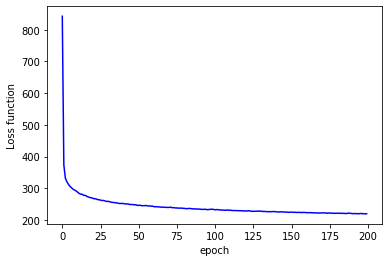

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('Loss function')
plt.show()

In [ ]:
forecast=[]

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=False))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

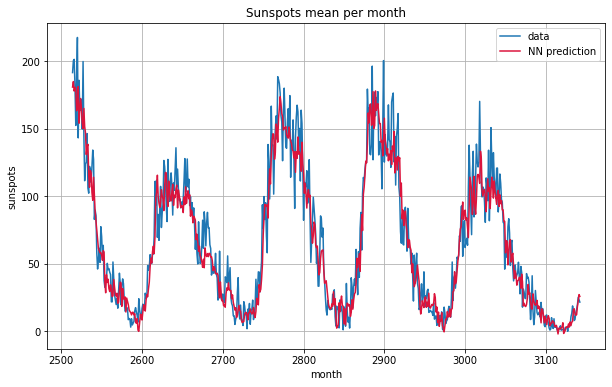

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(time_test, x_test, label='data')
plt.plot(time_test, results, c = 'crimson', label='NN prediction')
plt.title('Sunspots mean per month')
plt.xlabel(r'month')
plt.ylabel(r'sunspots')
plt.grid()
plt.legend()
plt.show()

In order to measure the accuracy of the algorithm, we will use the [**M**ean **A**bsolute **E**rror](https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class) (**MAE**) metric  

In [ ]:
tf.keras.metrics.mean_absolute_error(x_test, results).numpy()

12.388416